In [559]:
from math import *
import pandas as pd
import numpy as np

In [560]:
class DeviceInfo():
    def __init__(self, sm_num=0, sharedmem_per_sm=0, reg_per_sm=0, maxthreads_per_sm=0):
        self.sm_num = sm_num
        self.sharedmem_per_sm = sharedmem_per_sm # bytes
        self.reg_per_sm = reg_per_sm
        self.maxthreads_per_sm = maxthreads_per_sm
        
class KernelInfo():
    def __init__(self, blockDim=0, gridDim=0, reg_per_thread=0, sharedmem_per_blk=0, runtime_ms = 0):
        self.blockDim = blockDim
        self.gridDim = gridDim
        self.reg_per_thread = reg_per_thread
        self.sharedmem_per_blk =  sharedmem_per_blk
        self.runtime_ms = runtime_ms

In [561]:
def MaxBLK_Per_SM(Gpu, Kern):
    """
    Compute the max blocks on one SM
    """
    warp_size = 32
    DeviceLimit = Gpu.maxthreads_per_sm / 32
    
    blocks_by_sm = DeviceLimit
    
    if Kern.sharedmem_per_blk > 0:
        blocks_by_sm = floor(Gpu.sharedmem_per_sm / float(Kern.sharedmem_per_blk)) # int operation
        
    blocks_by_reg = floor(Gpu.reg_per_sm / float(Kern.reg_per_thread * Kern.blockDim))
    
    blocks_by_threads = floor(Gpu.maxthreads_per_sm / float(Kern.blockDim))
    
    # maxblks_per_sm
    return min([blocks_by_sm, blocks_by_reg, blocks_by_threads])

In [562]:
def compute_avgblktime(Gpu, kernel):
    max_blk_per_sm = MaxBLK_Per_SM(Gpu, kernel)
    print('max blk per sm = {}'.format(max_blk_per_sm))
    
    # max blocks that can be launhed on gpu at once time
    # if there are more blocks, they will wait for the next iteration
    # each SM starts and finishes at the same time
    # all the blocks on that SM starts and ends at the same time
    block_per_iteration = Gpu.sm_num * max_blk_per_sm

    iterations = ceil(kernel.gridDim / block_per_iteration) # total iterations
    #print 'iterations ' + str(iterations)

    # divide the kernel runtime by the number of iterations will be the avg block exeuction time for our model
    avg_blk_time = kernel.runtime_ms / float(iterations)
    #print('avg block execution time (ms) : {}'.format(avg_blk_time))
    
    return avg_blk_time

### Setup GPU info

In [563]:
gtx950 = DeviceInfo()
gtx950.sm_num = 2
gtx950.sharedmem_per_sm = 49152
gtx950.reg_per_sm = 65536
gtx950.maxthreads_per_sm = 2048

### Setup kernel info

In [564]:
# simulate kernel number
kernel_num = 3

kernels = [KernelInfo() for i in range(kernel_num)]

kernels[0].blockDim = 512
kernels[0].gridDim = 10
kernels[0].reg_per_thread = 28
kernels[0].sharedmem_per_blk= 0
kernels[0].runtime_ms = 0.057249


kernels[1].blockDim = 512
kernels[1].gridDim = 10
kernels[1].reg_per_thread = 28
kernels[1].sharedmem_per_blk= 0
kernels[1].runtime_ms = 0.057249 * 0.5   # assume half runtime

kernels[2].blockDim = 512
kernels[2].gridDim = 10
kernels[2].reg_per_thread = 28
kernels[2].sharedmem_per_blk= 0
kernels[2].runtime_ms = 0.057249 * 2  # assume x2 runtime

### compute average block execution time

In [565]:
avg_blk_time_list = []

for kid in range(kernel_num):
    avg_blk_time_list.append(compute_avgblktime(gtx950, kernels[kid]))

max blk per sm = 4.0
max blk per sm = 4.0
max blk per sm = 4.0


In [566]:
avg_blk_time_list

[0.0286245, 0.01431225, 0.057249]

### Now we model the multiple kernel concurrent execution time

In [567]:
class sm_stat:
    def __init__(self, thread=0, reg=0, sharedmem = 0, full=0, batch = 1):
        self.thread = thread
        self.reg= reg
        self.sharedmem = sharedmem
        self.full = full
        self.batch = batch

    def init(self, Gpu):
        self.thread = Gpu.maxthreads_per_sm
        self.reg = Gpu.reg_per_sm
        self.sharedmem = Gpu.sharedmem_per_sm
        self.full = 0 
        self.batch = 1
    
    def replenish(self, Gpu):
        self.thread = Gpu.maxthreads_per_sm
        self.reg = Gpu.reg_per_sm
        self.sharedmem = Gpu.sharedmem_per_sm
        self.full = 0 
        self.batch += 1 # add
        
    def Rm(self, Kern):
        """
        Remove the kernel block occupied resource by adding back them.
        """
        self.thread += Kern.blockDim
        self.reg += Kern.reg_per_thread * Kern.blockDim
        self.sharedmem += Kern.sharedmem_per_blk

    def Allocate_block(self, Kern):
        self.thread -= Kern.blockDim
        self.reg -= Kern.reg_per_thread * Kern.blockDim
        self.sharedmem -= Kern.sharedmem_per_blk

        
def check_sm_resource(current_sm, block_info):
    enough_thread = current_sm.thread >= block_info.blockDim
    enough_reg = current_sm.reg >= (block_info.reg_per_thread * block_info.blockDim)
    enough_sm = current_sm.sharedmem >= block_info.sharedmem_per_blk
    
    allocate = 0
    if enough_thread and enough_reg and enough_sm:
        allocate = 1
    
    return allocate

In [568]:
def Search_block_start(df_sm_trace, current_kernel_id):
    """
    Read the sm_trace table, find out all the active blocks on current sm, look for the earliest start
    """
    
    #df_active = df_sm_trace.loc[(df_sm_trace['active'] == 1) & (df_sm_trace['kernel_id'] == current_kernel_id)]
    df_active = df_sm_trace.loc[df_sm_trace['active'] == 1]
    blk2start = df_active['block_start'].max() # find the closest block
    
    df_active_current_kernel = df_active.loc[df_active['kernel_id'] == current_kernel_id]
    if not df_active_current_kernel.empty:
        blk2start = df_active_current_kernel['block_start'].max()  # find the closest blk for current kernel
    
    return blk2start 

### Modeling the execution and record the trace

In [569]:
# init SM status
sm_num = gtx950.sm_num
sms = [sm_stat() for i in range(sm_num)]

for i in range(sm_num):
    sms[i].init(gtx950)

In [570]:
# a trace table to record all the block trace: using pd dataframe
trace_table = pd.DataFrame(columns=['sm_id', 'block_id', 'block_start', 'block_end', 'batch_id', 'kernel_id', 'active'])

# have a trace table for each sm
sm_trace = [trace_table for x in range(gtx950.sm_num)]

In [571]:
# print len(sm_trace)
# print sm_trace[0]

In [572]:
sm2start = 0

for i in range(kernel_num):
    kern = kernels[i] # schedule current kernel on the device
    kernel_blocks = int(kern.gridDim) # total block for current kern
    
    last_block_on_sm = 0
    
    #print sm2start
    
    for bid in range(kernel_blocks):
        # find out which sm to allocate
        sm_id = (bid + sm2start) % sm_num
        
        # check whether current sm has enough resources to host the block
        to_allocate_another_block = check_sm_resource(sms[sm_id], kern)
        
        #print('kernel {} , bik {}, smid {}, to_allocate_another_block = {}'.format(i, bid, sm_id, to_allocate_another_block))

        #-------------------------------------------
        # There is no more resources to host the blk, consider SM is full now
        # we need to (1) decide how many blks to retire (2) when to start current blk
        #-------------------------------------------
        if to_allocate_another_block == 0:
            # find the list blocks to retire
            df_sm = sm_trace[sm_id]
            df_activeblk = df_sm.loc[df_sm['active'] == 1]
            #print df_activeblk
            
            # print sm_trace[sm_id]
            
            blkend_min = df_activeblk['block_end'].min()
            # print('blkend_min = {}'.format(blkend_min))
            
            df_blk2end = df_activeblk.loc[df_activeblk['block_end'] == blkend_min]
            for index, row in df_blk2end.iterrows():
                sm_trace[sm_id].loc[index]['active'] = 0 # retire the block
                sms[sm_id].Rm(kern) # free the block resource
            
            #print('blkid {}'.format(bid))
            
            # print sm_trace[sm_id]
            
            # after retiring some blocks, we have resources to allocate current block
            sms[sm_id].Allocate_block(kern)
            
            
            block_start = blkend_min # when prev blks end, current block starts
            block_end = block_start + avg_blk_time_list[i] # add avgblktime for currrent kernel
            
            # update the trace table
            sm_trace[sm_id] = sm_trace[sm_id].append({'sm_id': sm_id, 
                                                      'block_id': bid, 
                                                      'block_start': block_start,
                                                      'block_end' : block_end,
                                                      'batch_id': sms[sm_id].batch,
                                                      'kernel_id': i,
                                                      'active': 1}, ignore_index=True)
        
        #----------------------------------
        # there is enough resource to host the current block
        #----------------------------------
        if to_allocate_another_block == 1:
            # allocate the block on current sm
            sms[sm_id].Allocate_block(kern)

            # register the block in the trace table
            block_start = None

            # if current sm trace table is empty, start from 0
            # else find the blocks that will end soon, and retire them
            if sm_trace[sm_id].empty:
                block_start = 0
            else:
                # read the sm_trace table, find out all the active blocks on current sm, look for the earliest start
                block_start = Search_block_start(sm_trace[sm_id], i)

            block_end = block_start + avg_blk_time_list[i]

            # add the current block info to the current sm
            sm_trace[sm_id] = sm_trace[sm_id].append({'sm_id': sm_id, 
                                                      'block_id': bid, 
                                                      'block_start': block_start,
                                                      'block_end' : block_end,
                                                      'batch_id': sms[sm_id].batch,
                                                      'kernel_id': i,
                                                      'active': 1}, ignore_index=True)
        last_block_on_sm = sm_id
        
    # end of running previous kernel blocks
    sm2start = (last_block_on_sm + 1) % sm_num # start from next smd

In [573]:
#sm_trace[0]

In [574]:
#sm_trace[1]

### plot

/home/leiming/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


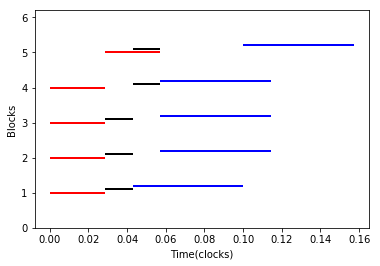

In [575]:
def Plot_sm_trace(df_sm):
    import matplotlib.pyplot as plt
    
    # color to pick
    color_list = ['r', 'k', 'b', 'g', 'c', 'm', 'y', '#cc0000', '#cc6600', 'cc9900',
                  '#cc3300', '#cccc00', '#99cc00', '#66cc00', '#00cccc', '#0033cc', 
                  '#6600cc', '#cc00cc', '#ff99cc', 'ffcc00']
    
    total_color = len(color_list) 
    
    kern_ids = df_sm['kernel_id'].unique()
    
    x0_dd = {}
    x1_dd = {}
    y0_dd = {}
    
    ylim_max = 0
    
    for kid in kern_ids:
        offset = 0.1 * kid
        df_kern = df_sm.loc[df_sm['kernel_id'] == kid] # get the data for current kernel on
        df_kern['y_axis'] = pd.Series(np.arange(1,len(df_kern.index)+1) + offset, 
                                      index=df_kern.index) # adding y_axis label
    
        x0_dd[kid] = df_kern['block_start']
        x1_dd[kid] = df_kern['block_end']
        y0_dd[kid] = df_kern['y_axis']

        current_ymax = max(df_kern['y_axis']) + 1
    
        if ylim_max < current_ymax:
            ylim_max = current_ymax
    

    axes = plt.gca()
    axes.set_ylim([0, ylim_max])

    for kid in kern_ids:
        cid = int(kid) % total_color
        plt.hlines(y0_dd[kid], x0_dd[kid], x1_dd[kid], lw=2, color=color_list[cid])

    
                                
# #     plt.title('Memory Bound')
    plt.xlabel('Time(clocks)')
    plt.ylabel('Blocks')
    plt.show()
    

#---------------------
# plot
#---------------------
df_sm = sm_trace[0]

Plot_sm_trace(df_sm)